In [1]:
%gui wx
import sys
import os


notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ


os.environ["DIPY_HOME"] = "/data"


import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()


loadFSL()


import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess


In [2]:
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

11:16:19: Debug: Adding duplicate image handler for 'Windows bitmap file'
11:16:19: Debug: Adding duplicate animation handler for '1' type
11:16:19: Debug: Adding duplicate animation handler for '2' type
11:16:19: Debug: Adding duplicate image handler for 'Windows bitmap file'
11:16:19: Debug: Adding duplicate animation handler for '1' type
11:16:19: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:4675): Gtk-CRITICAL **: 11:16:19.372: gtk_window_resize: assertion 'height > 0' failed


In [4]:
# --- Load MRI runs ---
run1 = nib.load("tfMRI_MOTOR_LR.nii")
run2 = nib.load("tfMRI_MOTOR_RL.nii")

In [6]:
import os

# Define the file paths
run1 = "tfMRI_MOTOR_LR.nii"
run2 = "tfMRI_MOTOR_RL.nii"

# Get the global standard deviation (SD) from fslstats
def get_sd(file):
    sd = os.popen(f"fslstats {file} -V").read().split()[1]
    return float(sd)

# Get SD for both runs
sd_run1 = get_sd(run1)
sd_run2 = get_sd(run2)

# Rescale each file using fslmaths
os.system(f"fslmaths {run1} -div {sd_run1} {run1.replace('.nii', '_rescaled.nii')}")
os.system(f"fslmaths {run2} -div {sd_run2} {run2.replace('.nii', '_rescaled.nii')}")


0

In [7]:
from fsl.wrappers import mcflirt

In [8]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.expandvars('tfMRI_MOTOR_LR_rescaled.nii.gz'))


(ipykernel_launcher.py:4675): Gdk-WARNING **: 11:18:50.329: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [12]:
# Concatenate the 4D files
os.system("fslmerge -t concatenated_rescaled.nii.gz tfMRI_MOTOR_LR_rescaled.nii.gz tfMRI_MOTOR_RL_rescaled.nii.gz")


0

In [13]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.expandvars('concatenated_rescaled.nii.gz'))

In [14]:
functional_data_path = 'concatenated_rescaled.nii.gz'
moco_data_path = 'concatenated_rescaled_moco.nii.gz'

In [15]:
mcflirt(infile=functional_data_path,
        o=moco_data_path,
        plots=True,
        report=True,
        dof=6,
        mats=True)

Processed data will be saved as concatenated_rescaled_moco.nii.gz

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [284] to 8 mm pixels
Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][426][427][428][429][430][431][432][433][434][4

refnum = 284
Original_refvol = -1


Registering volumes ... [285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][315][316][317][318][319][320][321][322][323][324][325][326][327][328][329][330][331][332][333][334][335][336][337][338][339][340][341][342][343][344][345][346][347][348][349][350][351][352][353][354][355][356][357][358][359][360][361][362][363][364][365][366][367][368][369][370][371][372][373][374][375][376][377][378][379][380][381][382][383][384][385][386][387][388][389][390][391][392][393][394][395][396][397][398][399][400][401][402][403][404][405][406][407][408][409][410][411][412][413][414][415][416][417][418][419][420][421][422][423][424][425][426][427][428][429][430][431][432][433][434][435][436][437][438][439][440][441][442][443][444][445][446][447][448][449][450][451][452][453][454][455][456][457][458][459][460][461][462][463][464][465][466][467][468][469][470][471][472][473][474][475][476][477][478][479][

{}

In [16]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

In [17]:
mot_params = load_mot_params_fsl_6_dof('concatenated_rescaled_moco.nii.gz.par')
mot_params


,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.000420,-0.005720,-0.002596,-0.338834,-0.165609,0.140364
1,0.000352,-0.005849,-0.002684,-0.328067,-0.161017,0.155873
2,0.000514,-0.005973,-0.002738,-0.330433,-0.160253,0.157223
3,0.000413,-0.005869,-0.002767,-0.322764,-0.154482,0.160955
4,0.000392,-0.006034,-0.002363,-0.337006,-0.152679,0.147477
...,...,...,...,...,...,...
563,0.000390,0.000927,-0.000503,0.064014,-0.036654,0.063090
564,0.000398,0.000966,-0.000450,0.066028,-0.033968,0.063099
565,0.000562,0.000921,-0.000479,0.059996,-0.045025,0.056997
566,0.000454,0.000958,-0.000481,0.064017,-0.037839,0.066265


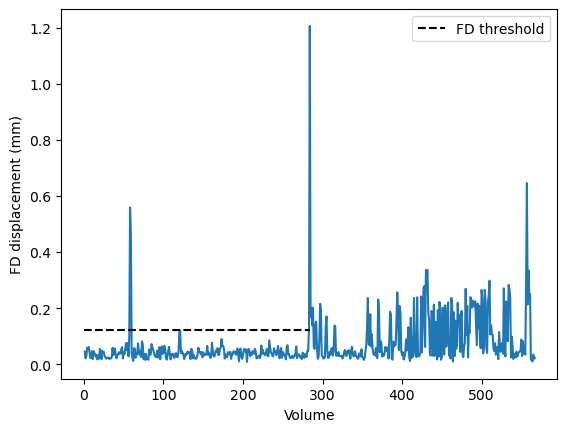

In [18]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

import matplotlib.pyplot as plt

#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 284,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()



In [21]:
functional_data_path_LR = 'tfMRI_MOTOR_LR_rescaled.nii.gz'
moco_data_path_LR = 'tfMRI_MOTOR_LR_rescaled_moco.nii.gz'

functional_data_path_RL = 'tfMRI_MOTOR_RL_rescaled.nii.gz'
moco_data_path_RL = 'tfMRI_MOTOR_RL_rescaled_moco.nii.gz'


In [22]:
mcflirt(infile=functional_data_path_LR,
        o=moco_data_path_LR,
        plots=True,
        report=True,
        dof=6,
        mats=True)

mcflirt(infile=functional_data_path_RL,
        o=moco_data_path_RL,
        plots=True,
        report=True,
        dof=6,
        mats=True)


Processed data will be saved as tfMRI_MOTOR_LR_rescaled_moco.nii.gz

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [142] to 8 mm pixels
Registering volumes ... [143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][141][140][139][138][137][136][135][134][133]

refnum = 142
Original_refvol = -1


Registering volumes ... [143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][118][117][116][115][114][113][112][111][110][109][108][107][106][105][104][103][102][101][100][99][98][97][96][95][94][93][92][91][90][89][88][87][86][85][

refnum = 142
Original_refvol = -1


Registering volumes ... [143][144][145][146][147][148][149][150][151][152][153][154][155][156][157][158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][118][117][116][115][114][113][112][111][110][109][108][107][106][105][104][103][102][101][100][99][98][97][96][95][94][93][92][91][90][89][88][87][86][85][

{}

In [23]:
mot_params_LR = load_mot_params_fsl_6_dof('tfMRI_MOTOR_LR_rescaled_moco.nii.gz.par')
mot_params

mot_params_RL = load_mot_params_fsl_6_dof('tfMRI_MOTOR_RL_rescaled_moco.nii.gz.par')
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.000420,-0.005720,-0.002596,-0.338834,-0.165609,0.140364
1,0.000352,-0.005849,-0.002684,-0.328067,-0.161017,0.155873
2,0.000514,-0.005973,-0.002738,-0.330433,-0.160253,0.157223
3,0.000413,-0.005869,-0.002767,-0.322764,-0.154482,0.160955
4,0.000392,-0.006034,-0.002363,-0.337006,-0.152679,0.147477
...,...,...,...,...,...,...
563,0.000390,0.000927,-0.000503,0.064014,-0.036654,0.063090
564,0.000398,0.000966,-0.000450,0.066028,-0.033968,0.063099
565,0.000562,0.000921,-0.000479,0.059996,-0.045025,0.056997
566,0.000454,0.000958,-0.000481,0.064017,-0.037839,0.066265


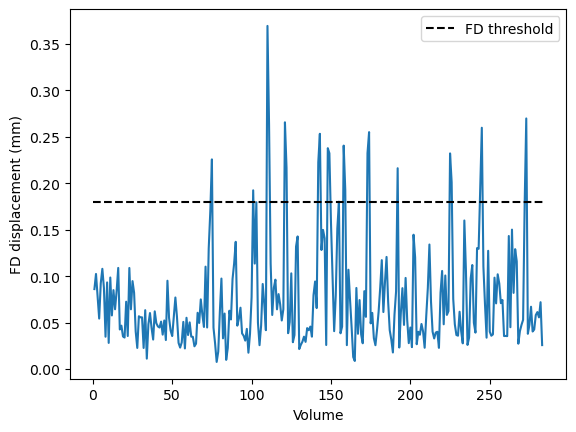

In [24]:
fd_RL = compute_FD_power(mot_params_RL).to_numpy()

threshold_RL = np.quantile(fd_RL,0.75) + 1.5*(np.quantile(fd_RL,0.75) - np.quantile(fd_RL,0.25))


#%matplotlib inline
plt.plot(list(range(1, fd_RL.size+1)), fd_RL)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold_RL, 0, fd_RL.size+1,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

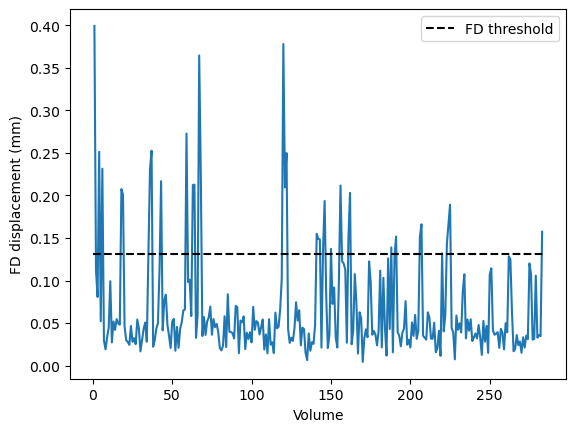

In [25]:
fd_LR = compute_FD_power(mot_params_LR).to_numpy()

threshold_LR = np.quantile(fd_LR,0.75) + 1.5*(np.quantile(fd_LR,0.75) - np.quantile(fd_LR,0.25))


#%matplotlib inline
plt.plot(list(range(1, fd_LR.size+1)), fd_LR)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold_LR, 0, fd_LR.size+1,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [28]:
# Detect volumes (timepoints) above threshold
outlier_indices_RL = np.where(fd_RL > threshold_RL)[0]

print(f"FD threshold: {threshold_RL:.4f}")
print(f"Outlier volumes: {outlier_indices_RL.tolist()}")

# ---- Store the outliers ----
# Option 1: Save as a NumPy array
np.save("fd_outliers_RL.npy", outlier_indices_RL)

# Option 2: Save as a simple text file (one index per line)
np.savetxt("fd_outliers_RL.txt", outlier_indices, fmt="%d")

FD threshold: 0.1802
Outlier volumes: [74, 100, 109, 110, 120, 121, 141, 142, 147, 148, 157, 158, 172, 173, 191, 224, 225, 243, 244, 272]


In [29]:
# Detect volumes (timepoints) above threshold
outlier_indices_LR = np.where(fd_LR > threshold_LR)[0]

print(f"FD threshold: {threshold_LR:.4f}")
print(f"Outlier volumes: {outlier_indices_LR.tolist()}")

# ---- Store the outliers ----
# Option 1: Save as a NumPy array
np.save("fd_outliers_LR.npy", outlier_indices_LR)

# Option 2: Save as a simple text file (one index per line)
np.savetxt("fd_outliers_LR.txt", outlier_indices_LR, fmt="%d")

FD threshold: 0.1316
Outlier volumes: [0, 3, 5, 17, 18, 35, 36, 42, 58, 62, 63, 66, 67, 119, 120, 121, 140, 141, 142, 144, 145, 149, 155, 160, 161, 187, 190, 205, 206, 219, 222, 223, 224, 282]
